In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
workers_data = pd.read_csv(r'C:\Users\Kris\Dropbox\PC\Downloads\Termina_case_study\diligence_initech.fake_initech_worker_data.csv')

In [12]:
income = pd.read_excel(r'C:\Users\Kris\Dropbox\PC\Downloads\Termina_case_study\diligence_initech.fake_initech_income_statement.xlsx')

In [13]:
income.head()

,Category,Sub-Category,Line Item,2023-06-01 00:00:00,2023-07-01 00:00:00,2023-08-01 00:00:00,2023-09-01 00:00:00,2023-10-01 00:00:00,2023-11-01 00:00:00,2023-12-01 00:00:00,...,2024-08-01 00:00:00,2024-09-01 00:00:00,2024-10-01 00:00:00,2024-11-01 00:00:00,2024-12-01 00:00:00,2025-01-01 00:00:00,2025-02-01 00:00:00,2025-03-01 00:00:00,2025-04-01 00:00:00,2025-05-01 00:00:00
0,Revenue,Revenue,Total Revenue,975,1060,1229,1140,1568,529,37,...,2216,2061,2939,982,273,1193,2337,2997,2447,2078
1,COGS,Direct Costs,Worker Pay,799,855,1018,944,1289,446,53,...,1783,1722,2433,880,209,892,1896,2375,1950,1797
2,NaN,NaN,Worker Bonuses,3,3,2,9,5,2,1,...,4,5,46,9,1,2,5,6,4,4
3,NaN,NaN,Employer Discounts,0,0,0,0,0,0,0,...,0,0,0,1,48,0,0,0,-1,0
4,NaN,Indirect Costs,Payment Processing,9,7,5,23,27,2,1,...,22,13,13,4,2,7,15,15,29,8


In [9]:
workers_data.head()

,month,worker_id,market,revenue,revenue_minus_direct_costs
0,2021-01-01,ZgJr9Oa6NQhBLV5HBB5H2W/1O8A=,other,0.0,0.0
1,2021-01-01,ZgJr9Oa6NQhBLV5HBB5H2W/1O8A=,sf-bay-area,250.0,0.0
2,2021-02-01,fq2P7dtIfEytINxlBgEww0/I26s=,sf-bay-area,750.0,0.0
3,2021-02-01,lLyFgmbQMRthsn0n1pqo53zytsk=,sf-bay-area,500.0,0.0
4,2021-02-01,cpLOvO77S36kwnJi7RxW5901iXU=,sf-bay-area,250.0,0.0


In [8]:
workers_data["month"] = pd.to_datetime(workers_data["month"])

In [10]:
workers_data.isna().sum()

month                         0
worker_id                     0
market                        0
revenue                       0
revenue_minus_direct_costs    0
dtype: int64

In [19]:
workers_data = workers_data.rename(columns={"revenue_minus_direct_costs" : "net_take"})

In [24]:
workers_data.head()

,month,worker_id,market,revenue,net_take
0,2021-01-01,ZgJr9Oa6NQhBLV5HBB5H2W/1O8A=,other,0.0,0.0
1,2021-01-01,ZgJr9Oa6NQhBLV5HBB5H2W/1O8A=,sf-bay-area,250.0,0.0
2,2021-02-01,fq2P7dtIfEytINxlBgEww0/I26s=,sf-bay-area,750.0,0.0
3,2021-02-01,lLyFgmbQMRthsn0n1pqo53zytsk=,sf-bay-area,500.0,0.0
4,2021-02-01,cpLOvO77S36kwnJi7RxW5901iXU=,sf-bay-area,250.0,0.0


In [23]:
workers_data = workers_data.drop("Total revenue", axis=1)

In [ ]:
# Create a dataframe workers-months in which we calculate total revenue per worker id and net take
wm = (workers_data
      .groupby(["worker_id", "month"], as_index = False)
      .agg(
          revenue=("revenue","sum"),
          net_take=("net_take","sum")
      )
)

In [ ]:
# Only consider the workers which are active (revenue > 0)
wm["ActiveFlag"] = (wm["revenue"] > 0).astype(int)

In [ ]:
# We will add the starting month of each worker to use it later to help us in the cohorts and also see the retention rates.
cohort_month = (wm.loc[wm["ActiveFlag"] == 1]
                  .groupby("worker_id")["month"]
                  .min()
                  .rename("CohortMonth"))
wm = wm.merge(cohort_month, on="worker_id", how="left")

In [ ]:
# Since the question is to be answered in monthly , create a new df in which we group the active workers and aggregate their monthly revenue and net take
monthly = (wm.loc[wm["ActiveFlag"] == 1]
             .groupby("month", as_index=False)
             .agg(
                 MAW=("worker_id", "nunique"),                 # Monthly Active Workers
                 revenue=("revenue", "sum"),
                 net_take=("net_take", "sum"),
             )
             .sort_values("month")
          )

In [ ]:
# To help us the see the trends in MAW,Revenue and net take we make MoM values for each column
# So basically its the percentage change in the value by their previous month value

monthly["MAW_MoM"] = monthly["MAW"].pct_change()
monthly["Revenue_MoM"] = monthly["revenue"].pct_change()
monthly["NetTake_MoM"] = monthly["net_take"].pct_change()

In [ ]:
# Take rate tells us what % of total revenue the company actually keeps as "net take"
# This is useful because revenue alone can grow, but if take rate drops the business may not be earning more per $ of revenue
monthly["take_rate"] = monthly["net_take"] / monthly["revenue"]  

# Revenue per active worker measures "worker productivity" on the platform
# on average, how much revenue is generated for each active worker in a month
# This helps us see if growth is coming from more active workers or from higher utilization per worker
monthly["rev_per_active_worker"] = monthly["revenue"] / monthly["MAW"]

# Net take per active worker measures how much the COMPANY earns per active worker per month
# it combines platform activity + take rate into one per-worker value metric
# This is helpful for comparing efficiency over time and for thinking about scaling
monthly["net_take_per_active_worker"] = monthly["net_take"] / monthly["MAW"]

In [41]:
monthly.head(20)

,month,MAW,revenue,net_take,MAW_MoM,Revenue_MoM,NetTake_MoM,take_rate,rev_per_active_worker,net_take_per_active_worker
0,2021-01-01,1,250.000,0.000000,NaN,NaN,NaN,0.000000,250.000000,0.000000
1,2021-02-01,7,5437.500,37.500000,6.000000,20.750000,inf,0.006897,776.785714,5.357143
2,2021-03-01,7,3988.500,86.700000,0.000000,-0.266483,1.312000,0.021737,569.785714,12.385714
3,2021-04-01,22,19691.880,2266.285500,2.142857,3.937164,25.139394,0.115087,895.085455,103.012977
4,2021-05-01,24,32081.660,4112.124000,0.090909,0.629182,0.814477,0.128177,1336.735833,171.338500
5,2021-06-01,43,59889.800,8383.032500,0.791667,0.866792,1.038614,0.139974,1392.786047,194.954244
6,2021-07-01,51,84327.130,12938.673000,0.186047,0.408038,0.543436,0.153434,1653.473137,253.699471
7,2021-08-01,77,106116.800,16007.502000,0.509804,0.258395,0.237183,0.150848,1378.140260,207.889636
8,2021-09-01,82,127859.700,19101.286500,0.064935,0.204896,0.193271,0.149393,1559.264634,232.942518
9,2021-10-01,96,158670.640,26243.281500,0.170732,0.240975,0.373901,0.165395,1652.819167,273.367516


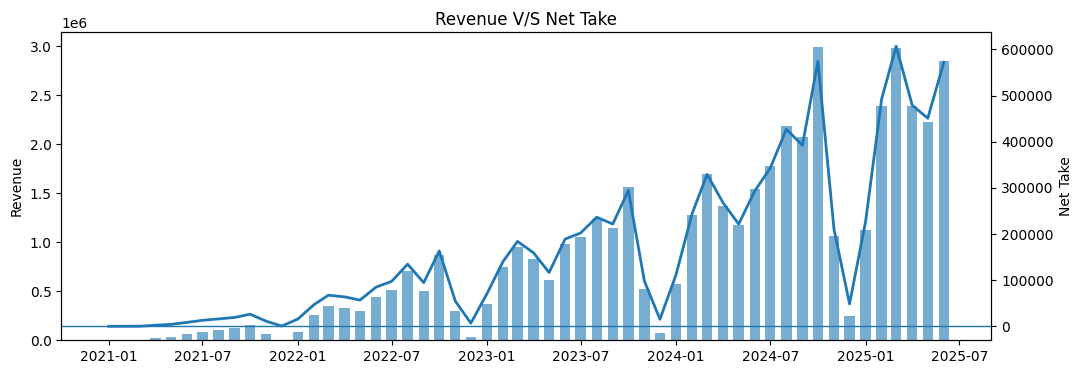

In [ ]:
df = monthly.sort_values("month").copy()

fig, ax1 = plt.subplots(figsize=(12,4))

ax1.bar(df["month"], df["revenue"], width=20, alpha=0.6)
ax1.set_ylabel("Revenue")

ax2 = ax1.twinx()
ax2.plot(df["month"], df["net_take"], linewidth=2)
ax2.axhline(0, linewidth=1)
ax2.set_ylabel("Net Take")



plt.title("Revenue V/S Net Take")
plt.show()

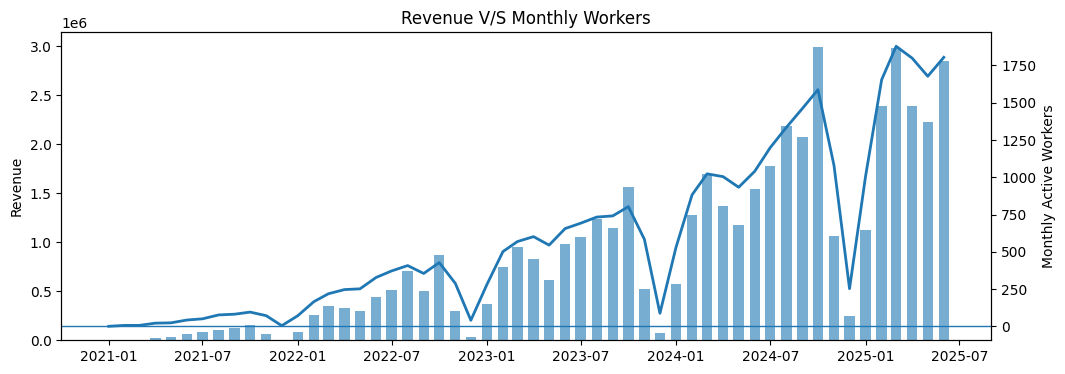

In [89]:
df = monthly.sort_values("month").copy()

fig, ax1 = plt.subplots(figsize=(12,4))

ax1.bar(df["month"], df["revenue"], width=20, alpha=0.6)
ax1.set_ylabel("Revenue")

ax2 = ax1.twinx()
ax2.plot(df["month"], df["MAW"], linewidth=2)
ax2.axhline(0, linewidth=1)
ax2.set_ylabel("Monthly Active Workers")



plt.title("Revenue V/S Monthly Workers")
plt.show()

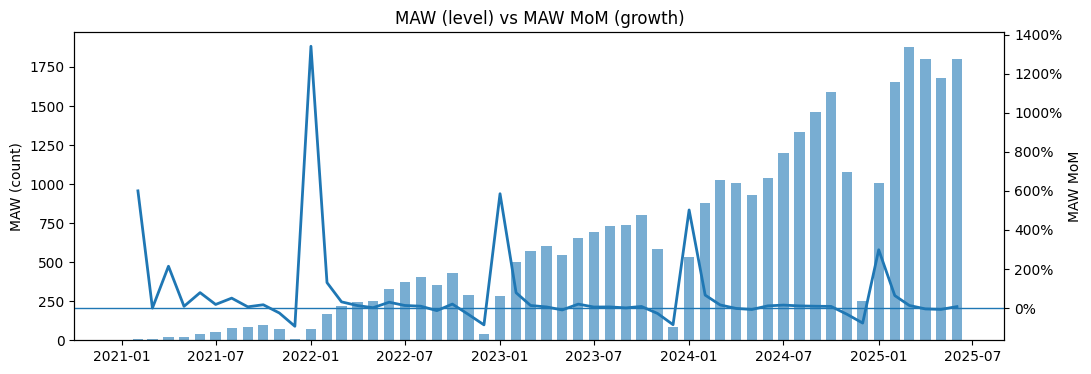

In [ ]:
import matplotlib.ticker as mtick

df = monthly.sort_values("month").copy()

fig, ax1 = plt.subplots(figsize=(12,4))

# Bars: MAW (level)
ax1.bar(df["month"], df["MAW"], width=20, alpha=0.6)
ax1.set_ylabel("MAW (count)")

# Line: MAW_MoM (growth) on 2nd axis
ax2 = ax1.twinx()
ax2.plot(df["month"], df["MAW_MoM"], linewidth=2)
ax2.axhline(0, linewidth=1)
ax2.set_ylabel("MAW MoM")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # if MoM is in decimals (0.10 = 10%)

plt.title("MAW (level) vs MAW MoM (growth)")
plt.show()

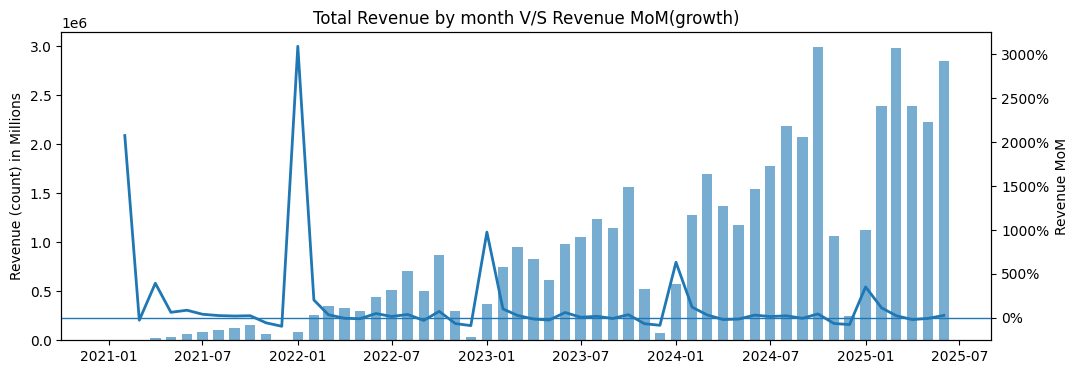

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

df = monthly.sort_values("month").copy()

fig, ax1 = plt.subplots(figsize=(12,4))

ax1.bar(df["month"], df["revenue"], width=20, alpha=0.6)
ax1.set_ylabel("Revenue (count) in Millions")


ax2 = ax1.twinx()
ax2.plot(df["month"], df["Revenue_MoM"], linewidth=2)
ax2.axhline(0, linewidth=1)
ax2.set_ylabel("Revenue MoM")
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # if MoM is in decimals (0.10 = 10%)

plt.title("Total Revenue by month V/S Revenue MoM(growth)")
plt.show()

### Q2

In [ ]:
# 1) Keep only worker-month rows where the worker was active.
active_wm = wm.loc[wm["ActiveFlag"] == 1].copy()

# 2) months_since_cohort = "age" of the worker in months since their first active month.
#    - 0 = cohort month (their first active month)
#    - 1 = 1 month after cohort month
#    - 12 = 12 months after cohort month, etc.
active_wm["months_since_cohort"] = (
    (active_wm["month"].dt.year - active_wm["CohortMonth"].dt.year) * 12
    + (active_wm["month"].dt.month - active_wm["CohortMonth"].dt.month)
)

# 3) Cohort size = number of UNIQUE workers who started (first became active) in each CohortMonth.
#    denominator for retention.
#    Example: If 100 workers first became active in 2022-01, cohort_size for 2022-01 = 100.
cohort_sizes = (
    active_wm.loc[active_wm["months_since_cohort"] == 0]
    .groupby("CohortMonth")["worker_id"]
    .nunique()
    .rename("cohort_size")
    .reset_index()
)

# 4) Active workers by cohort age:
#    For each cohort month and each month offset since cohort,
#    count how many UNIQUE workers are active.
#    numerator for retention at that month age.
cohort_counts = (
    active_wm
    .groupby(["CohortMonth", "months_since_cohort"])["worker_id"]
    .nunique()
    .rename("active_workers")
    .reset_index()
)

# 5) Retention = active_workers / cohort_size
#    Interpretation:
#      retention=1.0 at months_since_cohort=0 
#      retention=0.70 at months_since_cohort=1 means 70% of that cohort came back next month.
cohort_ret = cohort_counts.merge(cohort_sizes, on="CohortMonth", how="left")
cohort_ret["retention"] = cohort_ret["active_workers"] / cohort_ret["cohort_size"]

cohort_ret.head(10)

,CohortMonth,months_since_cohort,active_workers,cohort_size,retention
0,2021-01-01,0,1,1,1.0
1,2021-01-01,1,1,1,1.0
2,2021-01-01,2,1,1,1.0
3,2021-01-01,3,1,1,1.0
4,2021-01-01,4,1,1,1.0
5,2021-01-01,5,1,1,1.0
6,2021-01-01,6,1,1,1.0
7,2021-01-01,7,1,1,1.0
8,2021-01-01,8,1,1,1.0
9,2021-01-01,9,1,1,1.0


In [ ]:
# We want a table where:
#   - each ROW is a cohort month (the month workers first became active)
#   - each COLUMN is how many months since that cohort month (0,1,2, etc.)
#   - each CELL is retention (what % of that cohort is still active)
# This makes it easy to visually compare retention across cohorts.

retention_matrix = (cohort_ret
                    .pivot(index="CohortMonth", columns="months_since_cohort", values="retention")
                    .sort_index())


retention_matrix.index = retention_matrix.index.to_period("M").astype(str)
# CohortMonth is a datetime, but in a cohort table it’s easier to read as "YYYY-MM"

# Show first 12 months of retention
retention_matrix.loc[:, 0:12]
# We usually focus on the early months (0 to 12) because:
#  - most churn happens early
#  - newer cohorts won’t have data for very long ages yet
# Missing values on the right side are normal for newer cohorts (they haven't existed long enough).

months_since_cohort,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2021-01,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000
2021-02,1.0,0.666667,0.666667,0.500000,0.666667,0.500000,0.333333,0.500000,0.500000,0.166667,NaN,0.166667,0.166667
2021-03,1.0,0.500000,0.500000,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,NaN
2021-04,1.0,0.687500,0.687500,0.437500,0.562500,0.562500,0.500000,0.437500,0.062500,0.375000,0.312500,0.375000,0.250000
2021-05,1.0,0.875000,0.875000,0.875000,0.625000,0.500000,0.125000,NaN,NaN,0.125000,NaN,NaN,NaN
2021-06,1.0,0.750000,0.650000,0.550000,0.500000,0.450000,NaN,0.300000,0.350000,0.500000,0.400000,0.300000,0.250000
2021-07,1.0,0.722222,0.555556,0.555556,0.277778,0.055556,0.166667,0.111111,0.166667,0.111111,0.166667,0.111111,0.111111
2021-08,1.0,0.750000,0.687500,0.531250,0.031250,0.312500,0.406250,0.250000,0.218750,0.218750,0.218750,0.250000,0.218750
2021-09,1.0,0.894737,0.684211,NaN,0.105263,0.263158,0.263158,0.210526,0.263158,0.263158,0.368421,0.315789,0.263158


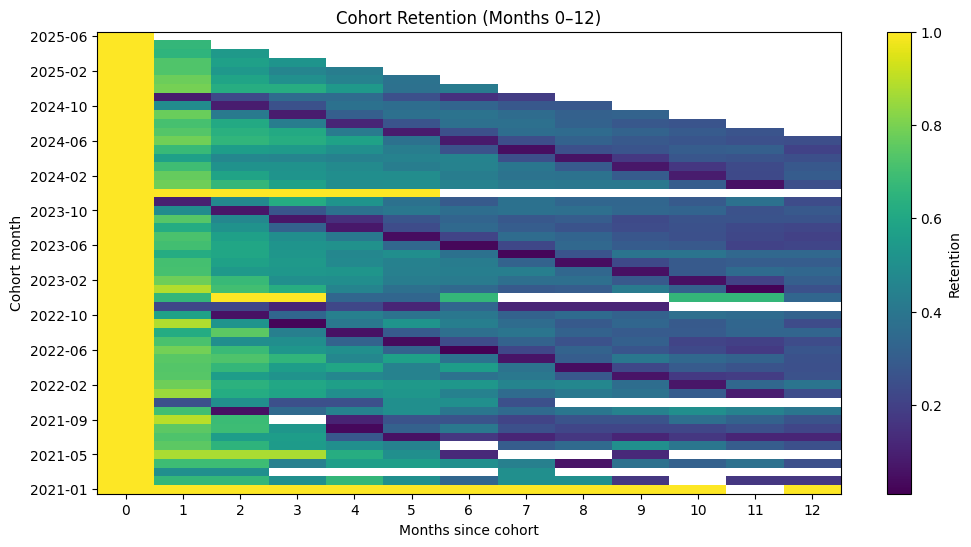

In [91]:
import numpy as np
import matplotlib.pyplot as plt

rm = retention_matrix.copy()
rm.columns = pd.to_numeric(rm.columns, errors="coerce")
rm = rm.sort_index().loc[:, 0:12]
rm = rm.loc[:, rm.columns.notna()]

data = rm.astype(float).to_numpy()

fig, ax = plt.subplots(figsize=(12, 6))
mesh = ax.pcolormesh(data)  # default colormap

ax.set_title("Cohort Retention (Months 0–12)")
ax.set_xlabel("Months since cohort")
ax.set_ylabel("Cohort month")

ax.set_xticks(np.arange(len(rm.columns)) + 0.5)
ax.set_xticklabels(rm.columns.astype(int))

yticks = np.arange(len(rm.index))
step = max(1, len(yticks)//12)
ax.set_yticks(yticks[::step] + 0.5)
ax.set_yticklabels(rm.index[::step])

plt.colorbar(mesh, ax=ax, label="Retention")
plt.show()

In [95]:
# The curve answers:
#   "Across the whole business, what % of workers are still active after N months?"
#
# We compute a weighted average so large cohorts influence the result more than tiny cohorts

# Weighted by cohort_size 
ret_curve = (cohort_ret
             .groupby("months_since_cohort")
             .apply(lambda d: np.average(d["retention"], weights=d["cohort_size"]))
             .rename("weighted_retention") # this is basically what % of workers came back after the first month
             .reset_index()
             .sort_values("months_since_cohort"))
#   Why weighted?
#     If one cohort has 1,000 workers and another has 10 workers,
#     we don't want the 10-worker cohort to affect the result equally.

ret_curve
# Shows the first 15 points of the blended retention curve
# (ex: month 0 retention should be ~1.0, month 1 shows how many came back next month, etc.)

C:\Users\Kris\AppData\Local\Temp\ipykernel_33008\2662561315.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: np.average(d["retention"], weights=d["cohort_size"]))


,months_since_cohort,weighted_retention
0,0,1.000000
1,1,0.700415
2,2,0.532862
3,3,0.458170
4,4,0.407033
5,5,0.364060
6,6,0.342354
7,7,0.320548
8,8,0.299672
9,9,0.269417


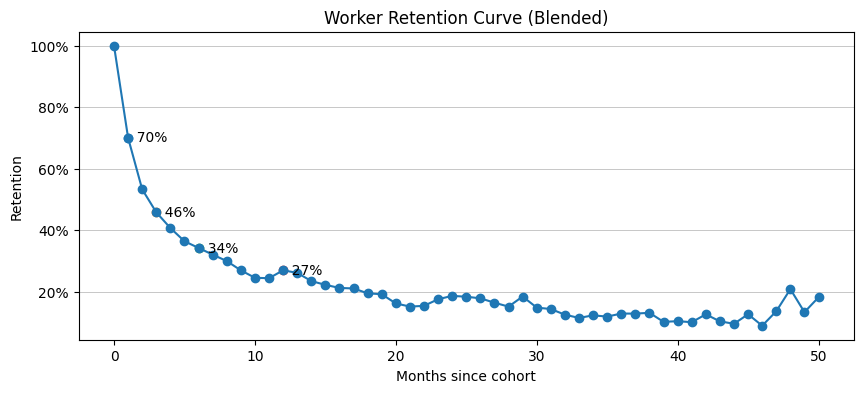

In [96]:
checkpoints = [1, 3, 6, 12]

df = ret_curve[ret_curve["months_since_cohort"] <= 50]

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df["months_since_cohort"], df["weighted_retention"], marker="o")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for c in checkpoints:
    if c in df["months_since_cohort"].values:
        y = df.loc[df["months_since_cohort"]==c, "weighted_retention"].iloc[0]
        ax.scatter([c], [y])
        ax.text(c, y, f"  {y:.0%}", va="center")

ax.set_title("Worker Retention Curve (Blended)")
ax.set_xlabel("Months since cohort")
ax.set_ylabel("Retention")
ax.grid(True, axis="y", linewidth=0.5)
plt.show()

### Q3

In [ ]:
# 1) Figure out how much value a typical ACTIVE worker generates at each "age" since joining
#    (e.g., month 0, month 1, month 2...).
# 2) Combine that with the retention curve from Q2 to estimate LTV over 6 months and 12 months.
# 3) Compare LTV to CAC (cost to acquire a worker) using Worker Marketing spend from the income statement.

# Value by cohort age:
# For each CohortMonth and each months_since_cohort (0,1,2,...),
# we compute:
#   - how many workers were active
#   - total net take earned from those workers
#   - total revenue generated by those workers
value_by_age = (active_wm
                .groupby(["CohortMonth", "months_since_cohort"])
                .agg(
                    active_workers=("worker_id", "nunique"),    # unique active workers at this cohort age
                    total_net_take=("net_take", "sum"),         # total net take from those workers
                    total_revenue=("revenue", "sum")            # total revenue from those workers
                )
                .reset_index()
                .merge(cohort_sizes, on="CohortMonth", how="left"))
# merge(cohort_sizes) brings in cohort_size so we can compute retention for that cohort + age.

# Retention at a specific cohort age = active_workers / cohort_size
# (This tells us what fraction of the original cohort is still active at that age.)
value_by_age["retention"] = value_by_age["active_workers"] / value_by_age["cohort_size"]

# Value per active worker at that cohort age:
# This tells us "when workers are active at age X, how much do they generate on average?"
value_by_age["net_take_per_active"] = value_by_age["total_net_take"] / value_by_age["active_workers"]
value_by_age["revenue_per_active"] = value_by_age["total_revenue"] / value_by_age["active_workers"]

# Weighted averages across cohorts (weights = active workers)
# We do this because:
#   - We want one "typical" value curve by age (0..N months).
#   - Bigger cohorts / more active workers should influence the average more than tiny cohorts.
avg_by_age = (value_by_age
              .groupby("months_since_cohort")
              .apply(lambda d: pd.Series({
                  # average net take per active worker at this age across all cohorts
                  "avg_net_take_per_active": np.average(d["net_take_per_active"], weights=d["active_workers"]),
                  # average revenue per active worker at this age across all cohorts
                  "avg_revenue_per_active": np.average(d["revenue_per_active"], weights=d["active_workers"]),
              }))
              .reset_index()
              .sort_values("months_since_cohort"))

avg_by_age.head(15)
# it shows how valuable an active worker is at month 0, month 1, month 2, ...

C:\Users\Kris\AppData\Local\Temp\ipykernel_33008\299645860.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({


,months_since_cohort,avg_net_take_per_active,avg_revenue_per_active
0,0,138.484895,721.904791
1,1,263.375821,1364.573770
2,2,287.256064,1489.034048
3,3,281.232580,1447.416736
4,4,298.596053,1545.382830
5,5,311.653259,1611.568139
6,6,319.941341,1661.619396
7,7,317.844809,1643.034955
8,8,313.561850,1625.895267
9,9,304.908831,1583.945931


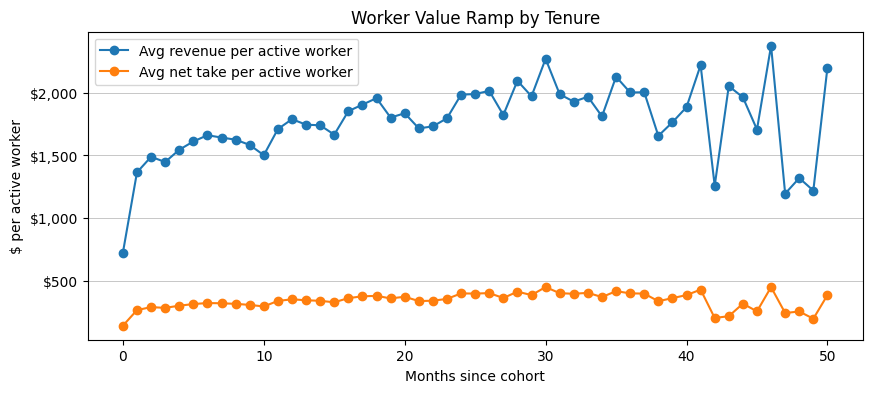

In [98]:
import matplotlib.ticker as ticker

df = avg_by_age.sort_values("months_since_cohort").copy()
df = df[df["months_since_cohort"] <= 50]  # keep it readable

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df["months_since_cohort"], df["avg_revenue_per_active"], marker="o", label="Avg revenue per active worker")
ax.plot(df["months_since_cohort"], df["avg_net_take_per_active"], marker="o", label="Avg net take per active worker")

ax.set_title("Worker Value Ramp by Tenure")
ax.set_xlabel("Months since cohort")
ax.set_ylabel("$ per active worker")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
ax.grid(True, axis="y", linewidth=0.5)
ax.legend()
plt.show()

In [ ]:
# LTV over a horizon = sum over each month age:
#   (probability the worker is still active at that age) * (value generated when active at that age)
#
# Here:
#   - ret_curve_df gives us the blended retention probability by age (weighted_retention)
#   - value_df gives us the blended value per active worker by age
def ltv_over_horizon(ret_curve_df, value_df, horizon_months, value_col):
    idx = range(0, horizon_months)  # e.g., 0..5 for 6 months

    # r = blended retention at each age (0..horizon-1)
    # If a value is missing, we treat retention as 0 (means no observed retention at that age)
    r = (ret_curve_df.set_index("months_since_cohort")["weighted_retention"]
         .reindex(idx).fillna(0))

    # v = value per active worker at each age
    # We forward-fill to handle missing ages (common for later months where data is sparse)
    v = (value_df.set_index("months_since_cohort")[value_col]
         .reindex(idx).ffill().fillna(0))

    # Multiply retention * value month-by-month and sum to get LTV
    return float((r * v).sum())

# LTV6 / LTV12 using net take
# Net take is what the company earns (better than gross revenue if we care about unit economics).
LTV6_net_take  = ltv_over_horizon(ret_curve, avg_by_age, 6,  "avg_net_take_per_active")
LTV12_net_take = ltv_over_horizon(ret_curve, avg_by_age, 12, "avg_net_take_per_active")

# Also compute the "revenue LTV" (sometimes useful for context)
# This tells us gross volume (revenue) per acquired worker over 6/12 months.
LTV6_revenue  = ltv_over_horizon(ret_curve, avg_by_age, 6,  "avg_revenue_per_active")
LTV12_revenue = ltv_over_horizon(ret_curve, avg_by_age, 12, "avg_revenue_per_active")

# Display blended (overall) LTV results (single row summary across the whole business)
pd.DataFrame([{
    "LTV6_net_take": LTV6_net_take,
    "LTV12_net_take": LTV12_net_take,
    "LTV6_revenue": LTV6_revenue,
    "LTV12_revenue": LTV12_revenue
}])

,LTV6_net_take,LTV12_net_take,LTV6_revenue,LTV12_revenue
0,839.876318,1381.25504,4350.014318,7144.891251


In [65]:
# Sometimes we want to check if newer cohorts are getting better or worse.
# This calculates LTV6/LTV12 separately for each CohortMonth (more detailed view).

# value_by_age already has: CohortMonth, months_since_cohort, retention, total_net_take, active_workers
# cohort_sizes has: CohortMonth, cohort_size

# Copy the table so we can safely do extra calculations without changing the original
v = value_by_age.copy()

# Recompute per-active metrics (same idea as above, but keeping cohort-level detail)
v["net_take_per_active"] = v["total_net_take"] / v["active_workers"]
v["revenue_per_active"] = v["total_revenue"] / v["active_workers"]

def cohort_ltv(df_one_cohort, horizon, value_col):
    # df_one_cohort contains months_since_cohort, retention, and value per active
    # We only keep ages within the horizon (example: first 6 months for LTV6)
    df = df_one_cohort[df_one_cohort["months_since_cohort"] < horizon].copy()

    # Ensure every age 0..horizon-1 exists
    # If an age is missing, we treat it as retention=0 (nobody active / no observation at that age)
    df = df.set_index("months_since_cohort").reindex(range(horizon)).fillna(0)

    # LTV for that cohort = sum(retention_at_age * value_at_age)
    return float((df["retention"] * df[value_col]).sum())

rows = []
for cm, g in v.groupby("CohortMonth"):
    # sort to make it easier to read/debug
    g = g.sort_values("months_since_cohort")

    # Calculate cohort-specific LTV6/LTV12
    rows.append({
        "CohortMonth": cm,
        "LTV6_net_take": cohort_ltv(g, 6,  "net_take_per_active"),
        "LTV12_net_take": cohort_ltv(g, 12, "net_take_per_active"),
        "LTV6_revenue": cohort_ltv(g, 6,  "revenue_per_active"),
        "LTV12_revenue": cohort_ltv(g, 12, "revenue_per_active"),

        # Include cohort_size so we remember whether a cohort is large (more reliable) or tiny (noisy)
        "cohort_size": int(cohort_sizes.loc[cohort_sizes["CohortMonth"]==cm, "cohort_size"].iloc[0])
    })

ltv_by_cohort = pd.DataFrame(rows).sort_values("CohortMonth")
ltv_by_cohort.head()

,CohortMonth,LTV6_net_take,LTV12_net_take,LTV6_revenue,LTV12_revenue,cohort_size
0,2021-01-01,0.000000,127.000000,2875.000000,6510.000000,1
1,2021-02-01,383.416667,479.083333,6667.083333,10791.250000,6
2,2021-03-01,76.600000,154.600000,1551.125000,1988.000000,2
3,2021-04-01,914.460625,1502.625551,5845.983125,9136.510313,16
4,2021-05-01,727.566875,738.339000,5755.706250,5823.353750,8


In [85]:
# CAC (Cost to Acquire a Worker) from income statement
# CAC by month is estimated as:
#   Worker Marketing Spend in that month / # new workers acquired in that month
#
# This is a proxy because it assumes marketing spend directly drives acquisition in that same month,
# but it’s still a common and useful approximation for unit economics.

# Identify the month columns (they're stored as datetime-like columns in this file)
month_cols = [c for c in income.columns if "202" in str(c) or isinstance(c, (pd.Timestamp,))]

# Pull Worker Marketing row from income statement
wmkt_row = income.loc[income["Line Item"] == "Worker Marketing"].iloc[0]

# Convert marketing spend into a time series indexed by month
# Income statement is in $000s, so multiply by 1000 to convert into dollars
worker_marketing = pd.Series({pd.to_datetime(m): wmkt_row[m] for m in month_cols})

# New workers per month = cohort_size in that month
# (cohort_size represents how many workers first became active in that month)
new_workers = cohort_sizes.set_index("CohortMonth")["cohort_size"]
new_workers = new_workers.reindex(worker_marketing.index).fillna(0)

# CAC for that month = marketing spend / new workers
# replace 0 with NaN to avoid division-by-zero errors
CAC_by_month = worker_marketing / new_workers.replace(0, np.nan)

# Show the monthly CAC calculation table
pd.DataFrame({
    "worker_marketing_spend": worker_marketing,
    "new_workers": new_workers,
    "CAC": CAC_by_month
}).reset_index().rename(columns={"index":"month"})

,month,worker_marketing_spend,new_workers,CAC
0,2023-06-01,74,146,0.506849
1,2023-07-01,69,95,0.726316
2,2023-08-01,107,110,0.972727
3,2023-09-01,94,107,0.878505
4,2023-10-01,74,92,0.804348
5,2023-11-01,55,21,2.619048
6,2023-12-01,95,1,95.000000
7,2024-01-01,76,147,0.517007
8,2024-02-01,93,224,0.415179
9,2024-03-01,54,216,0.250000


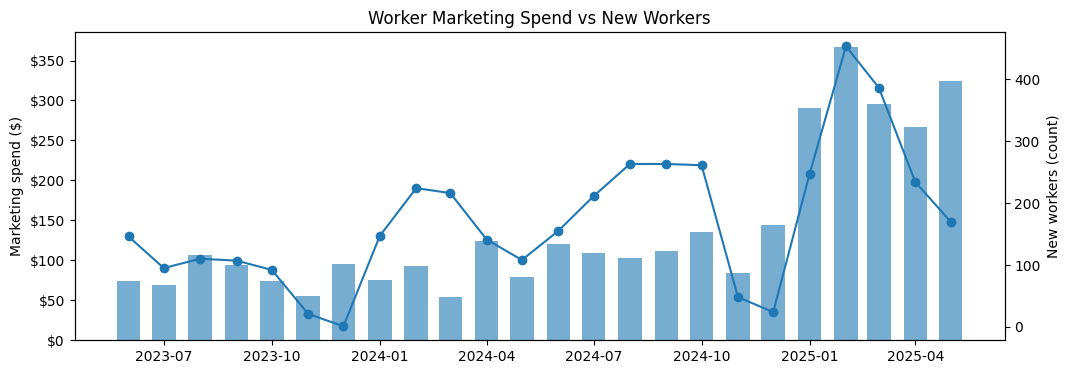

In [100]:
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick

tmp = pd.DataFrame({
    "worker_marketing_spend": worker_marketing,
    "new_workers": new_workers,
    "CAC": CAC_by_month
}).dropna().sort_index()

fig, ax1 = plt.subplots(figsize=(12,4))

ax1.bar(tmp.index, tmp["worker_marketing_spend"], width=20, alpha=0.6, label="Worker marketing spend")
ax1.set_ylabel("Marketing spend ($)")
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

ax2 = ax1.twinx()
ax2.plot(tmp.index, tmp["new_workers"], marker="o", label="New workers")
ax2.set_ylabel("New workers (count)")

plt.title("Worker Marketing Spend vs New Workers")
plt.show()


In [ ]:
# This tells us whether acquisition spend makes sense.
# If LTV is much larger than CAC, it suggests good unit economics.
# We use median CAC to reduce the effect of outlier months.

CAC_median = float(CAC_by_month.median())

summary_q3 = pd.DataFrame([{
    "CAC_median": CAC_median,
    "LTV6_net_take": LTV6_net_take,
    "LTV12_net_take": LTV12_net_take,
    "LTV6/CAC (net_take)": LTV6_net_take / CAC_median,
    "LTV12/CAC (net_take)": LTV12_net_take / CAC_median,
}])

summary_q3

,CAC_median,LTV6_net_take,LTV12_net_take,LTV6/CAC (net_take),LTV12/CAC (net_take)
0,0.792496,839.876318,1381.25504,1059.785531,1742.916279


In [69]:
# Gross-margin LTV (gmLTV) 
# gmLTV, meaning LTV after variable costs.
# We estimate a variable cost rate using:
#   Payment Processing % of revenue + Customer Support % of revenue
# from the income statement.
# Then we subtract those variable costs from revenue to get a rough gross profit proxy.

# Pull variable cost rows
rev_row = income.loc[income["Line Item"] == "Total Revenue"].iloc[0]
pp_row  = income.loc[income["Line Item"] == "Payment Processing"].iloc[0]
cs_row  = income.loc[income["Line Item"] == "Customer Support"].iloc[0]

# Convert these rows into dollar time series indexed by month
total_revenue = pd.Series({pd.to_datetime(m): rev_row[m] for m in month_cols}) * 1000
pay_proc = pd.Series({pd.to_datetime(m): pp_row[m] for m in month_cols}) * 1000
cust_support = pd.Series({pd.to_datetime(m): cs_row[m] for m in month_cols}) * 1000

# Median % of revenue as a proxy variable cost rate
# (Median is used to avoid noisy month-to-month fluctuations.)
var_rate = float(((pay_proc / total_revenue).median()) + ((cust_support / total_revenue).median()))

# Gross profit per active worker by cohort age (proxy)
# gross profit per active ≈ net take - (variable cost rate * revenue)
avg_by_age["avg_gross_profit_per_active"] = (
    avg_by_age["avg_net_take_per_active"] - var_rate * avg_by_age["avg_revenue_per_active"]
)

# Compute gmLTV over 6 and 12 months using the same retention curve logic
gmLTV6 = ltv_over_horizon(ret_curve, avg_by_age, 6,  "avg_gross_profit_per_active")
gmLTV12 = ltv_over_horizon(ret_curve, avg_by_age, 12, "avg_gross_profit_per_active")

pd.DataFrame([{
    "var_cost_rate_proxy": var_rate,
    "gmLTV6": gmLTV6,
    "gmLTV12": gmLTV12,
    "gmLTV6/CAC": gmLTV6 / CAC_median,
    "gmLTV12/CAC": gmLTV12 / CAC_median,
}])

,var_cost_rate_proxy,gmLTV6,gmLTV12,gmLTV6/CAC,gmLTV12/CAC
0,0.035804,684.12933,1125.440873,0.863258,1.420121


### Q4

In [ ]:
# The main idea:
# If IniTech expands, it matters WHERE they expand.
# Some markets might produce workers who are more valuable (higher LTV) than others.
#
# So we:
# 1) Assign each worker an "acquisition market" (the market where they started / first earned most revenue)
# 2) Compute LTV6 and LTV12 separately for each acquisition market
# 3) Rank markets by LTV to see where scaling could work best

# Define acquisition market as the market where the worker had the highest revenue in their cohort month
# First we aggregate worker-month-market data because a worker can appear multiple times.
wmm = (workers_data
       .groupby(["worker_id", "month", "market"], as_index=False)
       .agg(revenue=("revenue", "sum"), net_take=("net_take", "sum")))
# This gives us one row per worker per month per market with total revenue + net take.


wmm["ActiveFlag"] = (wmm["revenue"] > 0).astype(int)

# Find each worker's first active month (their cohort month).
first_active_month = (wmm.loc[wmm["ActiveFlag"] == 1]
                      .groupby("worker_id")["month"]
                      .min()
                      .rename("CohortMonth")
                      .reset_index())

# Attach CohortMonth back to the worker-market-month dataset
# so we can identify which market they started in.
wmm = wmm.merge(first_active_month, on="worker_id", how="left")

# Pick market with max revenue in the cohort month
# We look only at the cohort month rows because that’s the "start" month.
cohort_rows = wmm.loc[wmm["month"] == wmm["CohortMonth"]].copy()

# If a worker did activity in multiple markets in their cohort month,
# we assign the acquisition market as the market where they earned the most revenue.
acq_market = (cohort_rows.sort_values(["worker_id", "revenue"], ascending=[True, False])
                        .groupby("worker_id")["market"]
                        .first()
                        .rename("acq_market")
                        .reset_index())

# Attach acquisition market back to active_wm (the worker-month table used for retention/LTV)
# Now every worker has an associated "acq_market".
active_wm_mkt = active_wm.merge(acq_market, on="worker_id", how="left")


# Function to compute LTV over horizon for a subset (market)
# We basically repeat Q2 + Q3 calculations, but only for a subset of workers
# (ex: only workers acquired in NYC).
#
# This gives market-specific retention and market-specific worker value,
# which combine into market-specific LTV.
def market_ltv(active_subset, horizon=12):
    # Rebuild cohort retention + value for subset

    # Cohort size for the subset = how many workers started in each CohortMonth
    # (within this market subset)
    cohort_sizes_sub = (active_subset.loc[active_subset["months_since_cohort"] == 0]
                        .groupby("CohortMonth")["worker_id"].nunique()
                        .rename("cohort_size").reset_index())

    # Count how many unique workers are active at each cohort age
    counts = (active_subset.groupby(["CohortMonth","months_since_cohort"])["worker_id"]
              .nunique().rename("active_workers").reset_index())

    # Retention = active workers at age / cohort size
    ret = counts.merge(cohort_sizes_sub, on="CohortMonth", how="left")
    ret["retention"] = ret["active_workers"] / ret["cohort_size"]

    # Build a blended retention curve within this market subset
    # (weighted by cohort size so big cohorts matter more)
    ret_curve_sub = (ret.groupby("months_since_cohort")
                     .apply(lambda d: np.average(d["retention"], weights=d["cohort_size"]))
                     .rename("weighted_retention")
                     .reset_index()
                     .sort_values("months_since_cohort"))

    # Compute value (net take) by cohort age within this subset
    value = (active_subset.groupby(["CohortMonth","months_since_cohort"])
             .agg(active_workers=("worker_id","nunique"),
                  total_net_take=("net_take","sum"))
             .reset_index()
             .merge(cohort_sizes_sub, on="CohortMonth", how="left"))

    # Net take per active worker at that age (within this market subset)
    value["net_take_per_active"] = value["total_net_take"] / value["active_workers"]

    # Average value curve by cohort age (weighted by number of active workers)
    avg_value = (value.groupby("months_since_cohort")
                 .apply(lambda d: np.average(d["net_take_per_active"], weights=d["active_workers"]))
                 .rename("avg_net_take_per_active")
                 .reset_index()
                 .sort_values("months_since_cohort"))

    # Use the same LTV formula as Q3:
    # LTV = sum(retention_at_age * value_at_age) for the chosen horizon
    ltv = ltv_over_horizon(ret_curve_sub, avg_value, horizon, "avg_net_take_per_active")
    return ltv


# Compute market metrics (LTV6 and LTV12 per acquisition market)
rows = []
for mkt, df in active_wm_mkt.groupby("acq_market"):
    # Compute short-term and medium-term value
    ltv6 = market_ltv(df, horizon=6)
    ltv12 = market_ltv(df, horizon=12)

    # Count how many new workers were acquired in this market subset
    # (months_since_cohort == 0 means cohort month; unique workers there are "new workers")
    n_workers = df.loc[df["months_since_cohort"] == 0]["worker_id"].nunique()

    # Store results for ranking
    rows.append({"market": mkt, "new_workers": n_workers, "LTV6_net_take": ltv6, "LTV12_net_take": ltv12})

# Create a summary table and rank markets by LTV12 (longer horizon is more informative for scaling)
market_summary = pd.DataFrame(rows).sort_values("LTV12_net_take", ascending=False)
market_summary

C:\Users\Kris\AppData\Local\Temp\ipykernel_33008\3425760180.py:75: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: np.average(d["retention"], weights=d["cohort_size"]))
C:\Users\Kris\AppData\Local\Temp\ipykernel_33008\3425760180.py:92: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: np.average(d["net_take_per_active"], weights=d["active_workers"]))
C:\Users\Kris\AppData\Local\Temp\ipyker

,market,new_workers,LTV6_net_take,LTV12_net_take
6,other,20,1669.390691,3016.470619
3,los-angeles,1647,940.675435,1601.159141
8,washington-dc,324,837.417548,1401.732789
5,new-york-city,533,750.986776,1370.685577
7,sf-bay-area,2748,856.299755,1358.694573
2,kansas-city,34,641.816702,1271.566489
4,minneapolis,256,692.938618,1232.874681
1,chicago,21,833.621249,833.621249
0,austin,237,497.201049,831.480092
